In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!nvidia-smi

Sat Jan 14 15:06:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import data
import numpy as np

In [4]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

train_dir = '/content/drive/MyDrive/data_si/train'
valid_dir = '/content/drive/MyDrive/data_si/val'
test_dir = '/content/drive/MyDrive/data_si/test'

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 1868 files belonging to 36 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(valid_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 467 files belonging to 36 classes.


In [6]:
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE)

Found 180 files belonging to 36 classes.


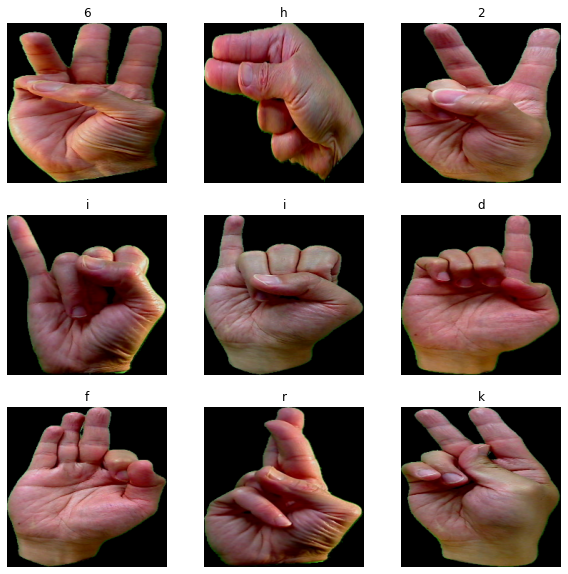

In [7]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomContrast(factor=0.7),
  tf.keras.layers.RandomBrightness(factor=0.7)
])

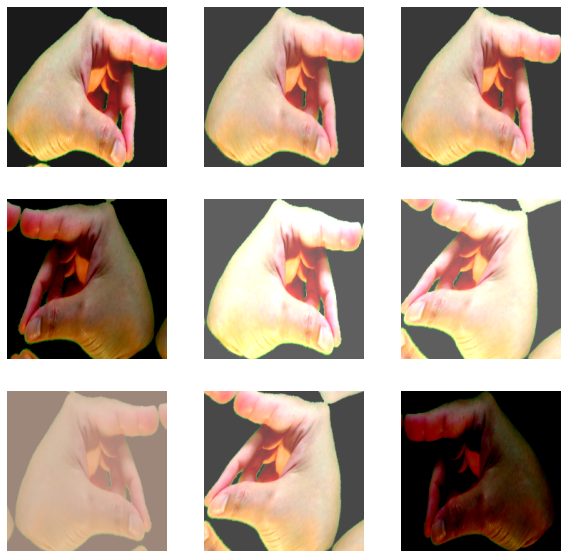

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [12]:
rescale = tf.keras.layers.Rescaling(1./255)

In [13]:
# Create the base model from the pre-trained model EfficientNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB5(input_shape=IMG_SHAPE,
                                                  include_top=False,
                                                  weights='imagenet')

115263384/115263384 [==============================] - 9s 0us/step


In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 2048)


In [15]:
base_model.trainable = False

In [16]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "efficientnetb5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0

In [17]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 2048)


In [18]:
prediction_layer = tf.keras.layers.Dense(36)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 36)


In [19]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb5 (Functional)  (None, 7, 7, 2048)       28513527  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 36)                73764     
                                                             

In [22]:
len(model.trainable_variables)

2

In [23]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(validation_dataset)

30/30 [==============================] - 152s 3s/step - loss: 3.6383 - accuracy: 0.0193


In [24]:
# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20


117/117 [==============================] - 549s 5s/step - loss: 3.5466 - accuracy: 0.0444 - val_loss: 3.3860 - val_accuracy: 0.1135
Epoch 2/20
117/117 [==============================] - 31s 263ms/step - loss: 3.3120 - accuracy: 0.1370 - val_loss: 3.1845 - val_accuracy: 0.2762
Epoch 3/20
117/117 [==============================] - 31s 260ms/step - loss: 3.1322 - accuracy: 0.2099 - val_loss: 3.0175 - val_accuracy: 0.3597
Epoch 4/20
117/117 [==============================] - 32s 273ms/step - loss: 2.9732 - accuracy: 0.2901 - val_loss: 2.8650 - val_accuracy: 0.4197
Epoch 5/20
117/117 [==============================] - 35s 298ms/step - loss: 2.8285 - accuracy: 0.3517 - val_loss: 2.7347 - val_accuracy: 0.4582
Epoch 6/20
117/117 [==============================] - 33s 275ms/step - loss: 2.7179 - accuracy: 0.3833 - val_loss: 2.6202 - val_accuracy: 0.4989
Epoch 7/20
117/117 [==============================] - 32s 266ms/step - loss: 2.6172 - accuracy: 0.3978 - val_loss: 2.5222 - val_accuracy: 0.501

20 mins to run above

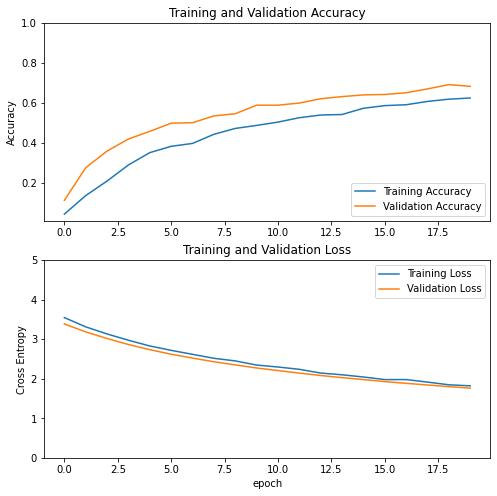

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, 5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig('train_val_acc_loss_efficientnetB5_si_before.png', dpi=300)
plt.show()

In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#   layer.trainable = False

Number of layers in the base model:  577


In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb5 (Functional)  (None, 7, 7, 2048)       28513527  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 36)                73764     
                                                             

In [31]:
len(model.trainable_variables)

506

In [32]:
fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40


117/117 [==============================] - 129s 790ms/step - loss: 1.1938 - accuracy: 0.6858 - val_loss: 0.6729 - val_accuracy: 0.8544
Epoch 21/40
117/117 [==============================] - 87s 742ms/step - loss: 0.7699 - accuracy: 0.7805 - val_loss: 0.4703 - val_accuracy: 0.8715
Epoch 22/40
117/117 [==============================] - 88s 749ms/step - loss: 0.6284 - accuracy: 0.8207 - val_loss: 0.3679 - val_accuracy: 0.8887
Epoch 23/40
117/117 [==============================] - 87s 743ms/step - loss: 0.5316 - accuracy: 0.8308 - val_loss: 0.2755 - val_accuracy: 0.9101
Epoch 24/40
117/117 [==============================] - 87s 742ms/step - loss: 0.4220 - accuracy: 0.8742 - val_loss: 0.2303 - val_accuracy: 0.9186
Epoch 25/40
117/117 [==============================] - 88s 750ms/step - loss: 0.3902 - accuracy: 0.8737 - val_loss: 0.2084 - val_accuracy: 0.9293
Epoch 26/40
117/117 [==============================] - 87s 743ms/step - loss: 0.3908 - accuracy: 0.8763 - val_loss: 0.2040 - val_accura

40 mins to run above

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

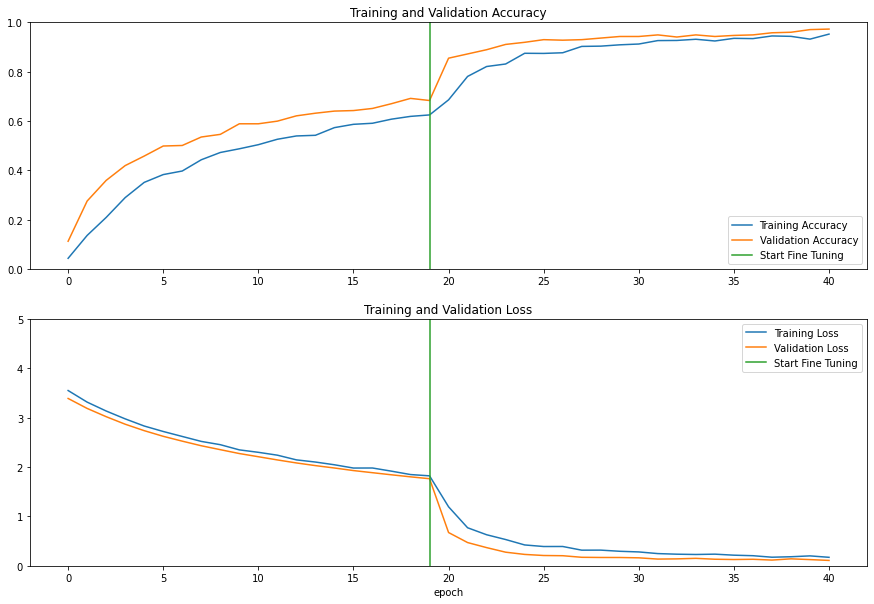

In [34]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.savefig('train_val_acc_loss_efficientnetB5_si_after.png', dpi=300)
plt.show()

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

12/12 [==============================] - 61s 1s/step - loss: 0.7238 - accuracy: 0.8056
Test accuracy : 0.8055555820465088


### Accuracy for Signer Independant using ResNet50 is 82.22%
### Accuracy for Signer Independant using ResNet50 with more data augmentation is 82.22%
### Accuracy for Signer Independant using EfficientNet B5 with more data augmentation is 84.44%

In [ ]:
img_height = 224
img_width = 224

img = tf.keras.utils.load_img(
    '/content/drive/MyDrive/output_ori/nine.jpeg', target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 36ms/step
This image most likely belongs to 4 with a 81.17 percent confidence.


In [ ]:
model.save('transfer_learning_efficientnetb5_si.h5')

NameError: ignored